#0. Imports

In [ ]:
!pip install torch-geometric

In [ ]:
!pip install ogb

In [ ]:
import torch
import torch_geometric
from ogb.nodeproppred import PygNodePropPredDataset
import torch_geometric.transforms as T
import torch.nn.functional as F
import copy

In [ ]:
from torch_geometric.nn import TransformerConv

# 1. UniMP Model

In [ ]:
class UniMP(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, beta=True, heads=1):
    super(UniMP, self).__init__()

    self.num_layers = num_layers
    self.dropout = dropout

    conv_layers = [TransformerConv(in_channels, hidden_channels//heads, heads, beta=beta)]
    conv_layers += [TransformerConv(hidden_channels, hidden_channels//heads, heads, beta=beta)]
    conv_layers.append(TransformerConv(hidden_channels, out_channels, heads, concat=False, beta=beta))
    self.convs = torch.nn.ModuleList(conv_layers)

    norm_layers = [torch.nn.LayerNorm(hidden_channels) for _ in range(self.num_layers-1)]
    self.norms = torch.nn.ModuleList(norm_layers)


  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()
    for norm in self.norms:
      norm.reset_parameters()

  def forward(self, x, edge_index):
    for i in range(self.num_layers-1):
      x = self.convs[i](x, edge_index)
      x = self.norms[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.convs[-1](x, edge_index)
    return x

#2. Training and Evaluation functions

In [ ]:
def train(model, data, loss_fn, optimizer, train_idx):
  model.train()

  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = loss_fn(out[train_idx], torch.flatten(data.y[train_idx]))
  # loss = loss_fn(out[train_idx], data.y[train_idx])
  loss.backward()
  optimizer.step()

  return loss.item()

In [ ]:
def test(model, data, split_idx):
  with torch.inference_mode():
    model.eval()

    preds = model(data.x, data.edge_index)
    preds_train = preds[split_idx['train']].argmax(dim=-1, keepdim=False)
    train_acc = (preds_train == data.y[split_idx['train']]).sum() / preds_train.size(0)

    preds_val = preds[split_idx['valid']].argmax(dim=-1, keepdim=False)
    val_acc = (preds_val == data.y[split_idx['valid']]).sum() / preds_val.size(0)

    preds_test = preds[split_idx['test']].argmax(dim=-1, keepdim=False)
    test_acc = (preds_test == data.y[split_idx['test']]).sum() / preds_test.size(0)

    return train_acc, val_acc, test_acc

#3. Dataset

In [ ]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='.', transform=T.ToUndirected())
dataset

/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

PygNodePropPredDataset()

In [ ]:
data = dataset[0]
data

Data(num_nodes=169343, edge_index=[2, 2315598], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
data.to(device)
data.y = data.y.view(-1)
split_idx = dataset.get_idx_split()
train_split = split_idx['train'].to(device)

#4. Configs and Training

In [ ]:
configs = {
    'device': device,
    'num_layers': 3,
    'hidden_channels': 128,
    'heads': 2,
    'dropout': 0.3,
    'lr': 0.001,
    'epochs': 500,
    'weight_decay': 0.0005,
}

model = UniMP(in_channels = data.num_features,
              hidden_channels = configs['hidden_channels'],
              out_channels = dataset.num_classes,
              num_layers = configs['num_layers'],
              dropout = configs['dropout'],
              heads = configs['heads'],
              ).to(device)

model

UniMP(
  (convs): ModuleList(
    (0-1): 2 x TransformerConv(128, 64, heads=2)
    (2): TransformerConv(128, 40, heads=2)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
)

In [ ]:
model.reset_parameters()

optimizer = torch.optim.Adam(params=model.parameters(), lr=configs['lr'], weight_decay=configs['weight_decay'])
loss_fn = F.cross_entropy

losses, train_accs, val_accs, test_accs = [], [], [], []
best_model = None
best_val_acc = 0

for epoch in range(1, configs['epochs']+1):
  loss = train(model, data, loss_fn, optimizer, train_split)
  losses.append(loss)
  train_acc, val_acc, test_acc = test(model, data, split_idx)
  if val_acc > best_val_acc:
    best_model = copy.deepcopy(model)
    best_val_acc = val_acc
  train_accs.append(train_acc)
  val_accs.append(val_acc)
  test_accs.append(test_acc)

  if epoch%10==0:
    print(f'Epoch: {epoch}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * val_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 10, Loss: 3.0851, Train: 28.17%, Valid: 30.24% Test: 27.09%
Epoch: 20, Loss: 2.6229, Train: 36.99%, Valid: 38.92% Test: 37.59%
Epoch: 30, Loss: 2.1630, Train: 48.62%, Valid: 51.61% Test: 50.55%
Epoch: 40, Loss: 1.8085, Train: 56.81%, Valid: 59.01% Test: 58.46%
Epoch: 50, Loss: 1.5717, Train: 61.35%, Valid: 62.90% Test: 62.60%
Epoch: 60, Loss: 1.4218, Train: 63.61%, Valid: 65.10% Test: 64.62%
Epoch: 70, Loss: 1.3251, Train: 65.47%, Valid: 66.01% Test: 65.24%
Epoch: 80, Loss: 1.2589, Train: 66.89%, Valid: 67.13% Test: 66.36%
Epoch: 90, Loss: 1.2124, Train: 67.94%, Valid: 67.90% Test: 66.74%
Epoch: 100, Loss: 1.1807, Train: 68.76%, Valid: 68.62% Test: 67.26%
Epoch: 110, Loss: 1.1544, Train: 69.32%, Valid: 69.14% Test: 68.00%
Epoch: 120, Loss: 1.1313, Train: 69.89%, Valid: 69.53% Test: 68.14%
Epoch: 130, Loss: 1.1166, Train: 70.28%, Valid: 69.89% Test: 68.68%
Epoch: 140, Loss: 1.1037, Train: 70.62%, Valid: 69.92% Test: 68.66%
Epoch: 150, Loss: 1.0881, Train: 70.89%, Valid: 69.94% Te

#5. Testing and Visualization

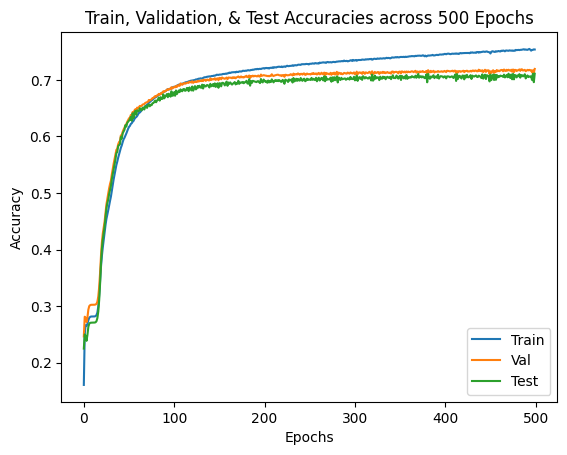

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(500)

# Convert each tensor in the list to a NumPy array after moving it to the CPU
train_accs = np.array([acc.cpu().numpy() for acc in train_accs])
val_accs = np.array([acc.cpu().numpy() for acc in val_accs])
test_accs = np.array([acc.cpu().numpy() for acc in test_accs])

plt.plot(x, train_accs, label='Train')
plt.plot(x, val_accs, label='Val')
plt.plot(x, test_accs, label='Test')

plt.title('Train, Validation, & Test Accuracies across 500 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
